In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'mean'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Mexican Gothic, Moreno-Garcia",296.961895,10.605782,19.166393,28
Azure Functions Core Tools,279.528958,16.442880,31.102392,17
Django,1370.569712,34.264243,48.449555,40
Node.js and Vite,1408.603859,34.356192,56.121107,41
OAuth 2.0 RFC6749,71.063593,35.531796,43.346569,2
Azure Files Documentation,2802.224307,46.703738,139.005130,60
CCH Tax Forms Project,1135.273746,54.060655,124.556090,21
Active Directory and Azure Files,2037.834452,55.076607,102.814652,37
Python + Oauth2.0,1459.937230,63.475532,135.189118,23
Accounting,1105.531560,65.031268,125.402279,17


# Histogram

sum of ages: ~53808.28


<Axes: >

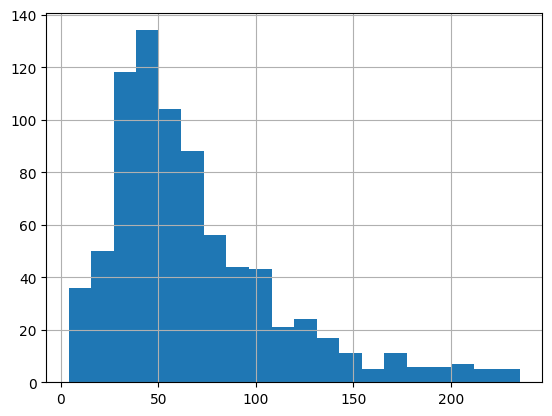

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~53808.28


<Axes: >

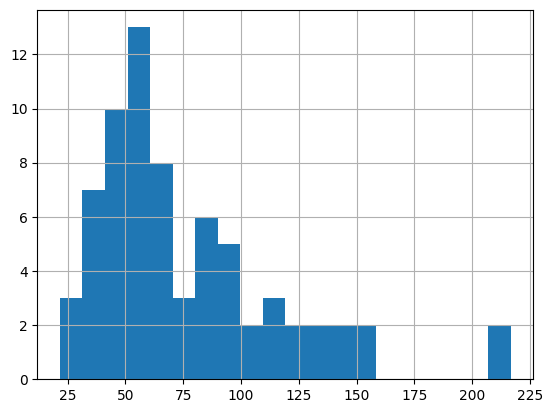

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
n = 3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 791
Total card age: 53808.28


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
117,Python,Q:\nExplain the difference between except Exce...,08e0f80ab4857ba50aa01fb3c0a2e07f,-216.725465,75.955119,216.725465,-5316.858323,0.244497,70,0,0
118,Python,Q:\nWhat is the purpose of the argparse module...,fcc998ede7082396948458af77e7e201,-151.088712,75.955119,216.725465,-5316.858323,0.244497,70,3,0
119,Python,Q:\nWhat are the two methods that a context ma...,643f631f1fddaab28a5b5e3ec787aa4e,-132.402924,75.955119,216.725465,-5316.858323,0.244497,70,6,0
120,Python,Q:\nWhat are some ways to optimize generator p...,dc313ddb954223c59b4d8c3046112873,-122.016120,75.955119,216.725465,-5316.858323,0.244497,70,9,0
121,Python,Q:\nWhich pathlib method can be used to get th...,f33aa72ead2a11d983db1b5bf4f7f4c0,-110.515431,75.955119,216.725465,-5316.858323,0.244497,70,12,0
395,Python,Q:\nWhat is the purpose of the raise ... from ...,3568df2062d1e05d4cd1c11c4c8326d9,-97.900578,75.955119,216.725465,-5316.858323,0.244497,70,15,0
396,Python,Q:\nWhat is the purpose of the leave parameter...,f499ada5fb234308afccf84f10578e6a,-92.104958,75.955119,216.725465,-5316.858323,0.244497,70,18,0
125,Python,Q:\nHow can generators be used to process stre...,f4942963d9465730fee27b2d554808a4,-85.894941,75.955119,216.725465,-5316.858323,0.244497,70,21,0
660,Python,Q:\nHow do you retrieve the next value from a ...,a787235de4d115775cc87fe026bf9266,-82.489770,75.955119,216.725465,-5316.858323,0.244497,70,24,0
661,Python,How do you resolve a relative path to an absol...,51bcf0bea82ec86eae6817d34b301707,-78.185383,75.955119,216.725465,-5316.858323,0.244497,70,27,0


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
# n=5
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(-1169.3242834009072)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
19,PnP PowerShell,App-Only Authentication\nA mode where applicat...,12d9bc97a1e6f53d3b7295eb85274bad,-235.062743,89.185069,235.062743,-3032.292354,0.356667,34,0,0
73,Terraform Codebox,A cloud-init.yaml.tpl file is a template for p...,e86be4b765ffee839b385a1a96ac3db1,-234.632957,81.495091,234.632957,-3830.269272,0.818590,47,0,0
5,Vocab,"Something Rotten, Fforde\nOwen Wister\n\nAn Am...",6a562f5734764178c0e8b1f11d0c3540,-233.121266,101.822306,233.121266,-3563.780703,0.610885,35,0,0
106,Power BI,Why can’t you reference a newly added column a...,a550364578e3469f2990bdec6904efc0,-227.981898,77.958752,227.981898,-2494.680064,0.462085,32,0,0
53,CCH Axcess,Security groups with any level of rights can b...,78f3ef96be8d308e501c9a70a0bc0c56,-225.909906,85.325914,225.909906,-4948.903012,0.801336,58,0,0
346,Terraform Codebox,Azure Files can be used to persist your coding...,9775a34a34e3610d8ddc43c1e0b44268,-216.745910,81.495091,234.632957,-3830.269272,0.818590,47,1,1
117,Python,Q:\nExplain the difference between except Exce...,08e0f80ab4857ba50aa01fb3c0a2e07f,-216.725465,75.955119,216.725465,-5316.858323,0.244497,70,0,0
327,CCH Axcess,Enable AutoText descriptions\nAllows you to cr...,5d78f7e45fe2c0dbf42b9c87b93c2224,-215.787601,85.325914,225.909906,-4948.903012,0.801336,58,1,1
47,Azure Compute Gallery,"Managed Image – A single, region-bound image s...",4099811ce9ab63014bfbe9d3999b3e32,-214.364273,88.998333,214.364273,-1601.969996,0.228935,18,0,0
390,Python,Q:\nWhat method do you call to parse the comma...,58c3e5284b8e017e25b1fe16b13cb52b,-213.178753,75.955119,216.725465,-5316.858323,0.244497,70,1,1


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 68.026'